In [1]:
import pandas as pd  # Добавляем импорт Pandas
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 1. Загрузка данных

In [3]:
# Модификации датасета:
# df_entire - датасет целиком AS IS на сейте
# df_encoded - датасет после применения LabelEncoder и преобразования InvoiceDate из типа 'object' в 'datetime64'
# df_no_missing - датасет с офильтрованныи пропусками в поле CustomerID - их не логично заполнять средним или мединным значением,
#                но можно не убирать при агрегированном среднесуточном анализе без разбивки по клиентам.
# df_next - датасет после выбора пользователем, сохранить или оставить покупателей без CustomerID
# df_sales - датасет только по продажам (без возвратов)
# df_sales_clean - датасет после очистки ошибок данных
# df_invoice_features - датасет дополнен фичами для каждого чека на основе группировки по InvoiceNo
# df_customer_features - датасет дополнен фичами для каждого покупателя на основе группировки по CustomerID
# df_date_features - датасет дополнен фичами для каждого дня на основе группировки по Date

In [4]:
# Импортируем функции для загрузки данных
from Modules.data_loader import data_load

# Загрузка данных
df_entire = data_load()

if df_entire is None:    
    print("\nОшибка: данные не загружены.")
    

Откуда вы хотите загрузить данные?
    Предпочтительнее загрузка данных из архива, т.к. на сайте отсутствуют поля ['InvoiceNo', 'StockCode'].
    Введите 'site' для загрузки с сайта или 'zip' для загрузки из архива: й


Ошибка: некорректный выбор источника данных. Применено значение по умолчанию zip
Данные загружены из файла: C:\Users\user\Documents\Belhard - Data Science\Practical tasks\HW_5\Modules\..\Data\online_retail_csv.csv


In [5]:
# 2. EDA анализ

In [6]:
# 2.1 Первичный просмотр датасета: поля, типы данных, статисический срез

# Импортируем функции для выполнения EDA
from Modules.eda import perform_eda, analyze_missing_values, analyze_returns, print_comparison_results

perform_eda(df_entire)


**Поля и типы данных:**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None

**Первые строки данных:**

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATE

In [7]:
# 2.2 Энкодирование категориальных переменных

# Импортируем функции для предварительной обработки
from Modules.preprocessing import preprocess_data

# Метод так же создает индекс CustomerID_missing, помечающий пропуски в CustomerID
df_encoded, label_encoders = preprocess_data(df_entire)


Трансформация данных и энкодирование категориальных переменных завершены. Файл сохранен в C:\Users\user\Documents\Belhard - Data Science\Practical tasks\HW_5\Data\label_encodings.txt.


In [8]:
# 2.3 Анализ пропущенных значений в CustomerID
analyze_missing_values(df_encoded)  # Явно передаем df_encoded и df_no_missing

print(f"""
Пропуски в поле CustomerID не логично заполнять средним или медианным значением - это может создать покупателя с аномальным поведением.
Для дальнейшей работы с агрегированными данными (прогноз всех покупок на дату) пропуски можно не убирать и отправлять в методы датасет df_entire.
Для прогноза по покупателям в анализ следует отправлять очищенный от пропусков датасет df_no_missing.""")

# Создание df_no_missing - датасета с отфильтрованными пропусками в поле CustomerID
df_no_missing = df_encoded[df_encoded['CustomerID_missing'] == 0]


Анализ данных без пропусков в CustomerID:
Количество строк в df_no_missing: 406829

**Поля и типы данных:**

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   InvoiceNo           406829 non-null  object        
 1   StockCode           406829 non-null  object        
 2   Description         406829 non-null  int64         
 3   Quantity            406829 non-null  int64         
 4   InvoiceDate         406829 non-null  datetime64[ns]
 5   UnitPrice           406829 non-null  float64       
 6   CustomerID          406829 non-null  int64         
 7   Country             406829 non-null  int64         
 8   CustomerID_missing  406829 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(2)
memory usage: 31.0+ MB
None

**Первые строки данных:**

  InvoiceNo StockCode  Description  Quantit

In [9]:
# Запрос у пользователя, стоит ли сохранять пропущенные CustomerID

missing_customer = input(f"""
Хотите сохранить клиентов без указанного CustomerID для дальнейшей обработки?
Введите 'y' для сохранения их в обработке или 'n' для исключения:
""")

if missing_customer.lower() == 'n':
    df_next = df_no_missing
    print("Покупатели без CustomerID исключены из дальнейшей обработки.")
elif missing_customer.lower() == 'y':
    df_next = df_encoded
    print("Покупатели без CustomerID сохранены в дальнейшей обработки.")
else:
    print("Ошибка: некорректный выбор. По умолчанию клиенты без указанного CustomerID исключены из дальнейшей обработки.")
    df_next = df_no_missing


Хотите сохранить клиентов без указанного CustomerID для дальнейшей обработки?
Введите 'y' для сохранения их в обработке или 'n' для исключения:
 ц


Ошибка: некорректный выбор. По умолчанию клиенты без указанного CustomerID исключены из дальнейшей обработки.


In [10]:
# 2.4 Анализ доли возвратов в датасете

print("Анализ доли возвратов:\n")
df_sales = analyze_returns(df_next)

print("\nПродолжаем работу с данными продаж (без возвратов)")

Анализ доли возвратов:

Столбец IsReturn добавлен:
  InvoiceNo StockCode  Description  Quantity         InvoiceDate  UnitPrice  \
0    536365    85123A         3918         6 2010-12-01 08:26:00       2.55   
1    536365     71053         3926         6 2010-12-01 08:26:00       3.39   
2    536365    84406B          913         8 2010-12-01 08:26:00       2.75   
3    536365    84029G         1910         6 2010-12-01 08:26:00       3.39   
4    536365    84029E         2911         6 2010-12-01 08:26:00       3.39   

   CustomerID  Country  CustomerID_missing  IsReturn  
0        4049       36                   0     False  
1        4049       36                   0     False  
2        4049       36                   0     False  
3        4049       36                   0     False  
4        4049       36                   0     False  
Количество возвратов: 8905
Сумма возвратов: -611342.09
Количество продаж: 397924
Сумма продаж: 8911407.90
Процент возвратов по количеству: 2.19%

In [11]:
# 3. Очистка данных

In [12]:
# Импортируем функции из модуля preprocessing
from Modules.preprocessing import clean_data

# Очистка данных
df_sales_clean = clean_data(df_sales)


Общее количество товаров до очистки: 5181696
Общая сумма продаж до очистки: 8911407.90

Инвойсы с разными InvoiceDate или CustomerID для одного InvoiceNo:
['536591' '540185' '541596' '541631' '541816' '541849' '542217' '542806'
 '543179' '543777' '544667' '544926' '545460' '546986' '547690' '549245'
 '550320' '550333' '550645' '553199' '553375' '553556' '554116' '558086'
 '562128' '563245' '567183' '571735' '576057' '578548']
Количество удаленных инвойсов: 30
Количество удаленых товаров: 12356
Доля от общего количества товаров: 0.24%
Сумма удаленых продаж: 19337.58
Доля от общей суммы продаж: 0.22%

Итоговое количество товаров после очистки: 5169340
Итоговая сумма продаж после очистки: 8892070.32

Итого удалено 0.24% от общего количества товаров и 0.22% от общей суммы продаж


In [13]:
# 4. Создание фичей

In [14]:
# Импортируем функции из модуля feature_engineering
from Modules.feature_engineering import create_invoice_features, create_customer_features, create_date_features, normalize_features

# Создание фичей для каждого чека
df_invoice_features = create_invoice_features(df_sales_clean)

print("Фичи для каждого чека:\n", df_invoice_features.head())

print("Статистика:\n", df_invoice_features.describe())

Фичи для каждого чека:
   InvoiceNo  TotalAmount  MinUnitPrice  MaxUnitPrice  MedianUnitPrice  \
0    536365       139.12          2.55          7.65             3.39   
1    536366        22.20          1.85          1.85             1.85   
2    536367       278.73          1.65          9.95             4.60   
3    536368        70.05          4.25          4.95             4.95   
4    536369        17.85          5.95          5.95             5.95   

   MinQuantity  MaxQuantity  TotalQuantity         InvoiceDate  CustomerID  
0            2            8             40 2010-12-01 08:26:00        4049  
1            6            6             12 2010-12-01 08:28:00        4049  
2            2           32             83 2010-12-01 08:34:00         541  
3            3            6             15 2010-12-01 08:34:00         541  
4            3            3              3 2010-12-01 08:35:00         541  
Статистика:
          TotalAmount  MinUnitPrice  MaxUnitPrice  MedianUnitPr

In [15]:
# Создание фичей для каждого абонента
df_customer_features = create_customer_features(df_invoice_features)

print("Фичи для каждого абонента:\n", df_customer_features.head())

print("Статистика:\n", df_customer_features.describe())

Фичи для каждого абонента:
    CustomerID   FirstPurchaseDate    LastPurchaseDate  TotalPurchaseCount  \
0           1 2011-01-18 10:01:00 2011-01-18 10:01:00                   1   
1           2 2010-12-07 14:57:00 2011-12-07 15:52:00                   7   
2           3 2010-12-16 19:09:00 2011-09-25 13:13:00                   4   
3           4 2011-11-21 09:51:00 2011-11-21 09:51:00                   1   
4           5 2011-02-02 16:01:00 2011-02-02 16:01:00                   1   

   TotalPurchaseAmount  AveragePurchaseAmount  TotalQuantity  \
0             77183.60           77183.600000          74215   
1              4310.00             615.714286           2458   
2              1797.24             449.310000           2341   
3              1757.55            1757.550000            631   
4               334.40             334.400000            197   

   DaysSinceFirstPurchase  LastMonthPurchaseAmount  
0                     325                     0.00  
1                 

In [16]:
# Создание фичей на основе группировки по дате
df_date_features = create_date_features(df_sales_clean)

print("Фичи на основе группировки по дате:\n", df_date_features.head())

print("Статистика:\n", df_date_features.describe())

Фичи на основе группировки по дате:
          Date  TotalSalesAmount  TotalSalesQuantity  AverageSalesAmount  \
0  2010-12-01          46178.17               24122           24.278743   
1  2010-12-02          47316.53               31142           23.658265   
2  2010-12-03          23921.71               11839           21.687860   
3  2010-12-05          31771.60               16450           11.732496   
4  2010-12-06          31215.64               16291           16.049172   

   AverageSalesQuantity  NumberOfTransactions  DayOfWeek  WeekOfYear  \
0             12.682440                   120          2          48   
1             15.571000                   137          3          48   
2             10.733454                    57          4          48   
3              6.074594                    87          6          48   
4              8.375835                    94          0          49   

   MonthOfYear  
0           12  
1           12  
2           12  
3          

In [17]:
# 5. Визуализация данных

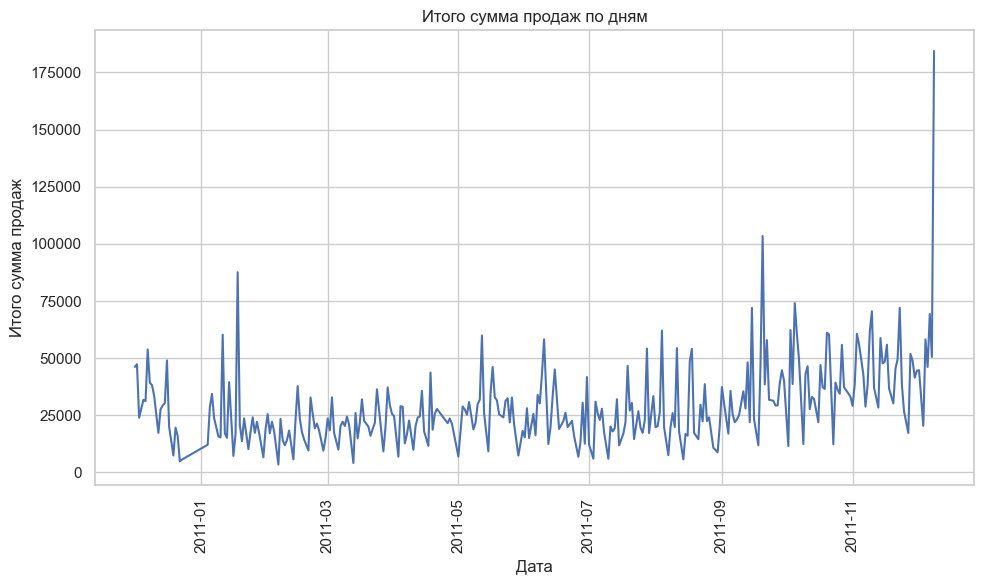

Сумма продаж имеет тренд на увеличение к концу 2011г.
Скорее всего в конце декабря 2010 начале января 2011 пропущено несколько дней


In [18]:
# Установка расширения autoreload
%load_ext autoreload
%autoreload 2

# Импортируем функции из модуля visualization
from Modules.visualization import plot_line_chart, visualize_missing_data, plot_heatmap, correlation_matrix


# Визуализация: Линейный график для Total Sales Amount по дням
plot_line_chart(df_date_features, 'Date', 'TotalSalesAmount', 'Итого сумма продаж по дням', 'Дата', 'Итого сумма продаж')

print("""Сумма продаж имеет тренд на увеличение к концу 2011г.
Скорее всего в конце декабря 2010 начале января 2011 пропущено несколько дней""")

Пропущенные даты на 51-52 неделях 2010г и 16-17 неделях 2011г:
         Date  Year  Week  DayOfWeek
3  2010-12-24  2010    51     Friday
4  2010-12-25  2010    51   Saturday
5  2010-12-26  2010    51     Sunday
6  2010-12-27  2010    52     Monday
7  2010-12-28  2010    52    Tuesday
8  2010-12-29  2010    52  Wednesday
9  2010-12-30  2010    52   Thursday
10 2010-12-31  2010    52     Friday
11 2011-01-01  2011    52   Saturday
12 2011-01-02  2011    52     Sunday
13 2011-01-03  2011     1     Monday
14 2011-01-08  2011     1   Saturday
29 2011-04-22  2011    16     Friday
30 2011-04-23  2011    16   Saturday
31 2011-04-24  2011    16     Sunday
32 2011-04-25  2011    17     Monday
33 2011-04-29  2011    17     Friday
34 2011-04-30  2011    17   Saturday
35 2011-05-02  2011    18     Monday
36 2011-05-07  2011    18   Saturday
40 2011-05-30  2011    22     Monday
41 2011-06-04  2011    22   Saturday
54 2011-08-29  2011    35     Monday
55 2011-09-03  2011    35   Saturday


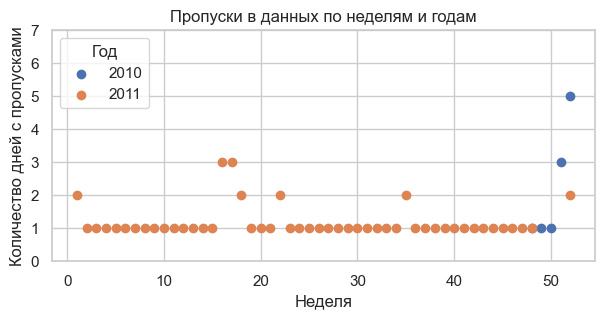

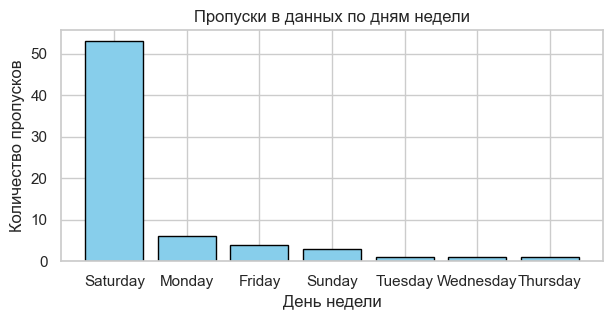

Подтвердилась гипотеза о пропусках на 51-52 неделях 2010г, а так же обнаружены частичные пропуски на 16-17 неделях 2011г.


In [19]:
%reload_ext autoreload
# Визуализация пропусков дней в данных
visualize_missing_data(df_date_features)

print("Подтвердилась гипотеза о пропусках на 51-52 неделях 2010г, а так же обнаружены частичные пропуски на 16-17 неделях 2011г.")


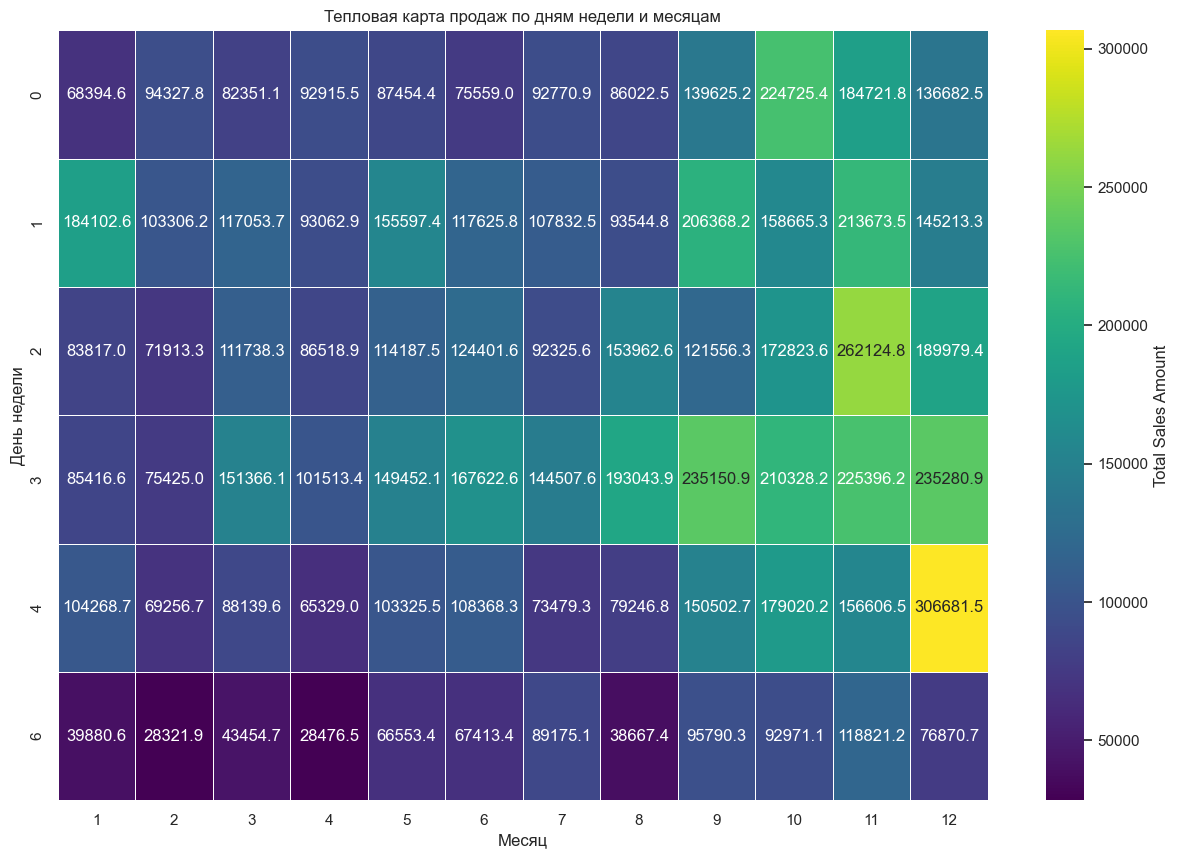

Самые 'тёплые' месяцы года - ноябрь и декабрь;
самый 'холодный' день недели - воскресенье.


In [20]:
# Установка расширения autoreload
%reload_ext autoreload

# Импортируем функцию из модуля visualization
from Modules.visualization import plot_heatmap

# Визуализация: Тепловая карта продаж по дням недели и месяцам
plot_heatmap(df_date_features, 'Тепловая карта продаж по дням недели и месяцам', 'Месяц', 'День недели')

print("""Самые 'тёплые' месяцы года - ноябрь и декабрь;
самый 'холодный' день недели - воскресенье.""")

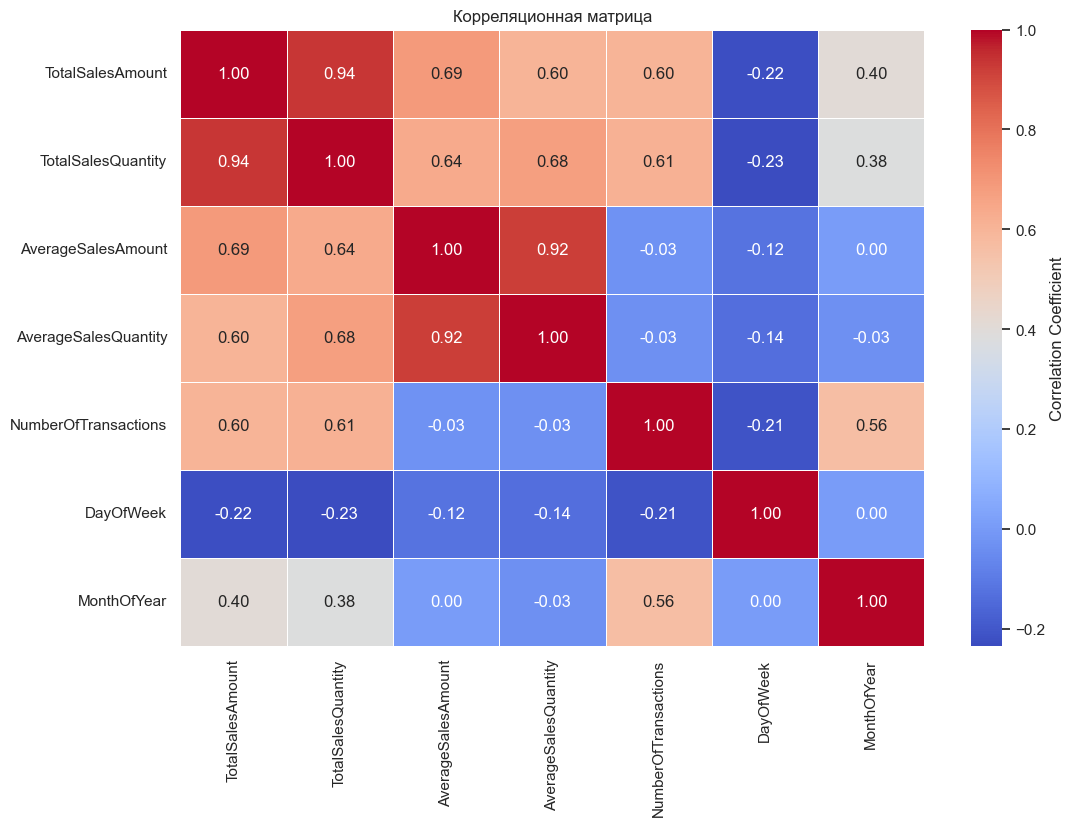

In [22]:
# Установка расширения autoreload
%reload_ext autoreload

# Визуализация: Матрица корреляций
correlation_matrix(df_date_features)

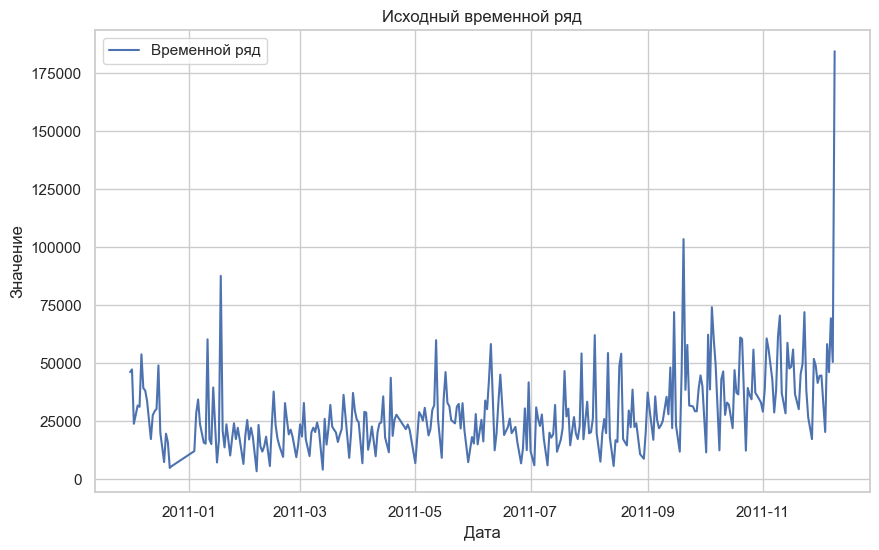

In [28]:
# Установка расширения autoreload
%reload_ext autoreload

import pandas as pd
from Modules.preprocessing import normalize_data, create_sequences
from Modules.visualization import visualize_time_series, visualize_residuals, visualize_forecast, visualize_residuals_test
from Modules.metrics import calculate_metrics, adf_test, ljung_box_test
from Modules.modeling import arima_model, sarima_model, lstm_model, gru_model, cnn_model

# Использование существующего датасета df_date_features
ts = df_date_features[['Date', 'TotalSalesAmount']]
ts.set_index('Date', inplace=True)

# Разделение данных на обучающую и тестовую выборки
train_size = int(len(ts) * 0.8)
train_data, test_data = ts[:train_size], ts[train_size:]

# Визуализация исходного временного ряда
visualize_time_series(ts, title='Исходный временной ряд')

In [29]:
from statsmodels.tsa.stattools import adfuller

# Проверка стационарности
adf_result = adf_test(train_data['TotalSalesAmount'])
if adf_result > 0.05:
    train_data_diff = train_data['TotalSalesAmount'].diff().dropna()
else:
    train_data_diff = train_data['TotalSalesAmount']


ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
"""
__________________________________________________________________________________________

Back up
__________________________________________________________________________________________
"""

In [ ]:
# Нормализация фичей
columns_to_normalize = ['TotalPurchaseAmount', 'AveragePurchaseAmount', 'TotalQuantity', 'LastMonthPurchaseAmount']
df_customer_features = normalize_features(df_customer_features, columns_to_normalize)